In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2DTranspose, Conv2D, Input, BatchNormalization, Activation, concatenate,Flatten,Dense,ReLU
)
import os
from tqdm import tqdm  # For progress tracking
import numpy as np 
from tensorflow.keras import layers
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio
from collections import Counter
import numpy as np
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

In [2]:
path = ''
image_path = os.path.join(path, 'data/images/')
mask_path = os.path.join(path, 'data/panoptic/')
image_list_orig = os.listdir(image_path)
mask_list_orig = os.listdir(mask_path)
image_list = [os.path.join(image_path, i) for i in image_list_orig if i.endswith('.jpg')][:2000]
mask_list = [os.path.join(mask_path, i) for i in mask_list_orig if i.endswith('.png')][:2000]

test_image_path = os.path.join(path, 'val_cityscapes/img/')
test_image_list_orig = os.listdir(test_image_path)
test_image_list = [test_image_path+i for i in test_image_list_orig if i.endswith('.png')]


In [3]:
def process_test_path(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (96, 128))
    return img

# Preprocess testing data
test_image_filenames = tf.constant(test_image_list)

# Convert to TensorFlow Dataset
test_image_ds = tf.data.Dataset.from_tensor_slices(test_image_filenames)

# Apply preprocessing function to the dataset
test_image_ds = test_image_ds.map(process_test_path)


C:\Users\Tanma\AppData\Local\Temp\ipykernel_8604\1645610153.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
C:\Users\Tanma\AppData\Local\Temp\ipykernel_8604\1645610153.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

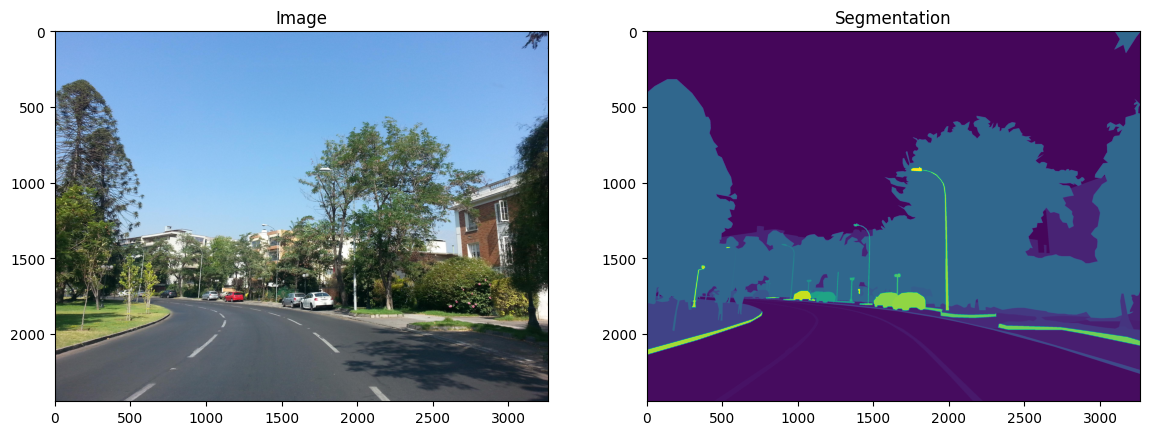

In [4]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [5]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\images\\--NSVcUgfVhFd6uzkqHOOg.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\panoptic\\--NSVcUgfVhFd6uzkqHOOg.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\images\\--SWG8TJo7vrbZ_x5YLj6A.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\panoptic\\--SWG8TJo7vrbZ_x5YLj6A.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'data\\images\\--WOpVBuHlCygAUADkttpg.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'data\\panoptic\\--WOpVBuHlCygAUADkttpg.png'>)


In [6]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

test_filenames = tf.constant(test_image_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))


for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'data/images/--jRsD9anHdGxv4ZOCQktA.jpg', shape=(), dtype=string)
tf.Tensor(b'data/panoptic/--jRsD9anHdGxv4ZOCQktA.png', shape=(), dtype=string)


In [7]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

num_classes = 124
def preprocess_labels(dataset, num_classes):
    def map_labels(image, label):
        label = tf.clip_by_value(label, 0, num_classes - 1)  # Clip to valid range
        return image, label
    return dataset.map(map_labels)

processed_image_ds = preprocess_labels(processed_image_ds, num_classes)

In [8]:
def create_lenet_segmentation(input_shape=(96, 128, 3), num_classes=124):
    """
    Creates a segmentation model using LeNet as the encoder.
    Supports RGB input (3 channels).
    """
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # LeNet Encoder
    # First convolutional block
    x = Conv2D(6, (5, 5), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Second convolutional block
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Third convolutional block
    x = Conv2D(120, (5, 5), activation='relu', padding='same')(x)
    
    # Decoder (Upsampling layers)
    # Upsample to 48x64
    x = Conv2DTranspose(120, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Upsample to 96x128
    x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Output layer for segmentation mask
    outputs = Conv2D(num_classes, 1, activation='softmax')(x)  # Softmax activation for multi-class segmentation
    
    # Create the model
    model = Model(inputs=inputs, outputs=outputs, name="LeNet_Segmentation")
    
    return model

In [9]:
input_shape = (96, 128, 3)
num_classes = 124
model = create_lenet_segmentation(input_shape=input_shape, num_classes=num_classes)

In [10]:
model.summary()

Model: "LeNet_Segmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 128, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 96, 128, 6)          │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 64, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 64, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 32, 120)         │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 48, 64, 120)         │         129,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 64, 120)         │             480 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 48, 64, 120)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 96, 128, 64)         │          69,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 96, 128, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 96, 128, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 96, 128, 124)        │           8,060 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 258,692 (1010.52 KB)

 Trainable params: 258,324 (1009.08 KB)

 Non-trainable params: 368 (1.44 KB)

In [11]:
def pixel_accuracy(y_true, y_pred):
    # Convert predicted probabilities to predicted labels
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    # Ensure y_pred_labels has the same shape as y_true
    y_pred_labels = tf.reshape(y_pred_labels, tf.shape(y_true))
    # Cast y_true to the same data type as y_pred_labels
    y_true = tf.cast(y_true, y_pred_labels.dtype)
    # Compare predicted labels to true labels and compute accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    return accuracy




def mean_iou_vectorized(y_true, y_pred, num_classes=124):
    """
    Compute mean IoU using a fully vectorized approach.
    """
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    
    # Flatten the tensors
    y_true = tf.reshape(y_true, [-1])
    y_pred_labels = tf.reshape(y_pred_labels, [-1])
    
    # Create a confusion matrix
    cm = tf.math.confusion_matrix(y_true, y_pred_labels, num_classes=num_classes, dtype=tf.float32)
    
    # Compute intersection and union
    intersection = tf.linalg.diag_part(cm)  # True positives for each class
    union = tf.reduce_sum(cm, axis=0) + tf.reduce_sum(cm, axis=1) - intersection  # Union = TP + FP + FN
    
    # Compute IoU for each class
    iou_per_class = tf.where(union > 0, intersection / union, tf.ones_like(intersection))
    
    # Compute mean IoU
    mean_iou = tf.reduce_mean(iou_per_class)
    return mean_iou


def precision(y_true, y_pred):
    """
    Compute Precision for segmentation.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits, shape (batch_size, height, width, num_classes).

    Returns:
        Precision as a scalar.
    """
    y_pred_labels = tf.argmax(y_pred, axis=-1)  # Convert logits to class labels
    
    # Remove the extra dimension in y_true if it exists
    y_true = tf.squeeze(y_true, axis=-1)  # Shape (batch_size, height, width)
    
    # Ensure consistency in data types (cast both to int64)
    y_true = tf.cast(y_true, tf.int64)
    y_pred_labels = tf.cast(y_pred_labels, tf.int64)

    # Exclude background class (0)
    true_positive = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    predicted_positive = tf.reduce_sum(tf.cast(tf.not_equal(y_pred_labels, 0), tf.float32))
    
    return true_positive / (predicted_positive + 1e-7)  # Avoid division by zero

def recall(y_true, y_pred):
    """
    Compute Recall.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits, shape (batch_size, height, width, num_classes).

    Returns:
        Recall as a scalar.
    """
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    
    # Remove the extra dimension in y_true if it exists
    y_true = tf.squeeze(y_true, axis=-1)
    
    # Ensure consistency in data types (cast both to int64)
    y_true = tf.cast(y_true, tf.int64)
    y_pred_labels = tf.cast(y_pred_labels, tf.int64)

    true_positive = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred_labels), tf.float32))
    actual_positive = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), tf.float32))  # Exclude background
    return true_positive / (actual_positive + 1e-7)  # Avoid division by zero


def f1_score(y_true, y_pred):
    """
    Compute F1 Score for segmentation.

    Args:
        y_true: Ground truth labels, shape (batch_size, height, width).
        y_pred: Predicted logits, shape (batch_size, height, width, num_classes).

    Returns:
        F1 Score as a scalar.
    """
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    
    return 2 * (precision_value * recall_value) / (precision_value + recall_value + 1e-7)

def compute_class_frequencies_optimized(mask_paths, num_classes):
    class_counts = np.zeros(num_classes, dtype=np.int64)
    total_pixels = 0

    for mask_path in tqdm(mask_paths, desc="Processing Masks"):
        mask = imageio.imread(mask_path)

        # Clip invalid values
        mask = np.clip(mask, 0, num_classes - 1)

        unique, counts = np.unique(mask, return_counts=True)
        class_counts[unique] += counts
        total_pixels += mask.size

    frequencies = class_counts / total_pixels
    return frequencies


# Call the optimized function
class_frequencies = compute_class_frequencies_optimized(mask_list, num_classes)


def weighted_sparse_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        # Convert class weights to a tensor
        class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)

        # Flatten y_true and y_pred for easier computation
        y_true_flat = tf.reshape(y_true, [-1])
        y_pred_flat = tf.reshape(y_pred, [-1, y_pred.shape[-1]])

        # Gather weights for each pixel based on its true class
        weights = tf.gather(class_weights_tensor, tf.cast(y_true_flat, tf.int32))

        # Compute SparseCategoricalCrossentropy loss
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_flat, y_pred_flat)

        # Multiply by weights and compute mean
        weighted_loss = loss * weights
        return tf.reduce_mean(weighted_loss)
    
    return loss






Processing Masks:   0%|                                                                       | 0/2000 [00:00<?, ?it/s]C:\Users\Tanma\AppData\Local\Temp\ipykernel_8604\3917679221.py:112: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path)
Processing Masks: 100%|████████████████████████████████████████████████████████████| 2000/2000 [33:56<00:00,  1.02s/it]


NameError: name 'weighted_sparse_categorical_crossentropy_optimized' is not defined

In [12]:
model.compile(
    optimizer='adam',
    loss=weighted_sparse_categorical_crossentropy(class_frequencies),
    metrics=[mean_iou_vectorized, pixel_accuracy,precision, recall,f1_score]  # Use simple metrics during training
)

In [13]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(3024, 4032, 1)


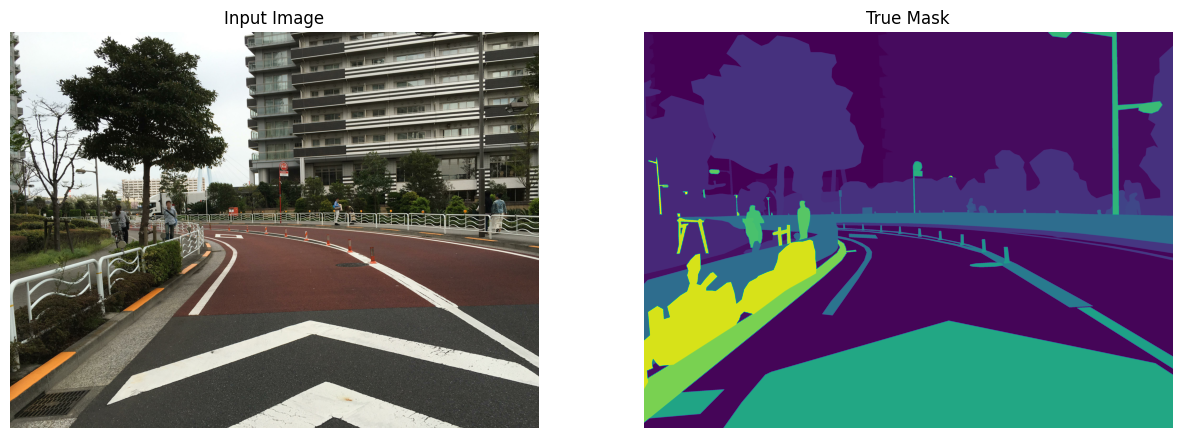

In [14]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


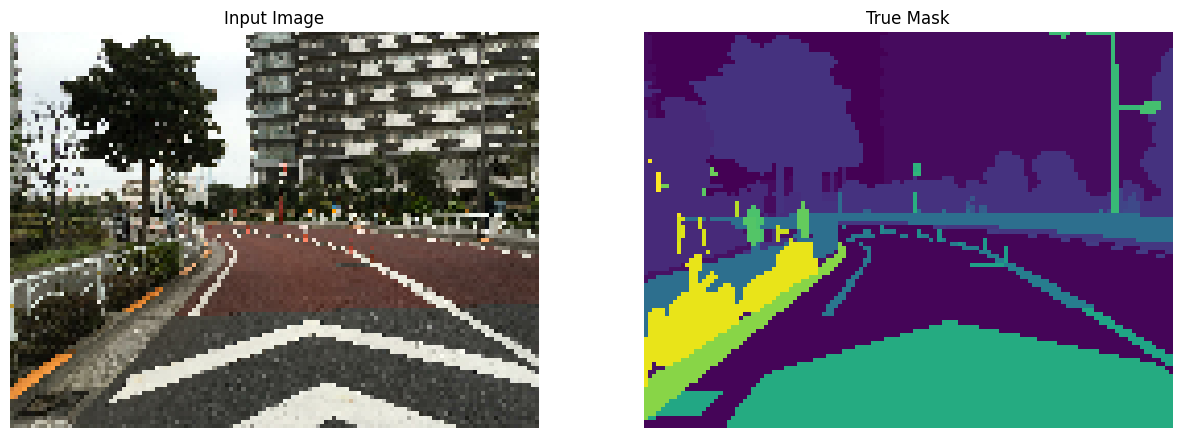

In [15]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [16]:
EPOCHS =150
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 4
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = model.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 116s 192ms/step - f1_score: 0.3374 - loss: 0.0592 - mean_iou_vectorized: 0.1033 - pixel_accuracy: 0.3202 - precision: 0.3563 - recall: 0.3208
Epoch 2/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 69s 138ms/step - f1_score: 0.3757 - loss: 0.0309 - mean_iou_vectorized: 0.1096 - pixel_accuracy: 0.3532 - precision: 0.4008 - recall: 0.3539
Epoch 3/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 69s 139ms/step - f1_score: 0.3845 - loss: 0.0303 - mean_iou_vectorized: 0.1124 - pixel_accuracy: 0.3650 - precision: 0.4056 - recall: 0.3657
Epoch 4/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 70s 140ms/step - f1_score: 0.3809 - loss: 0.0302 - mean_iou_vectorized: 0.1140 - pixel_accuracy: 0.3602 - precision: 0.4035 - recall: 0.3609
Epoch 5/150
500/500 ━━━━━━━━━━━━━━━━━━━━ 71s 141ms/step - f1_score: 0.3844 - loss: 0.0289 - mean_iou_vectorized: 0.1114 - pixel_accuracy: 0.3682 - pre

In [19]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [21]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


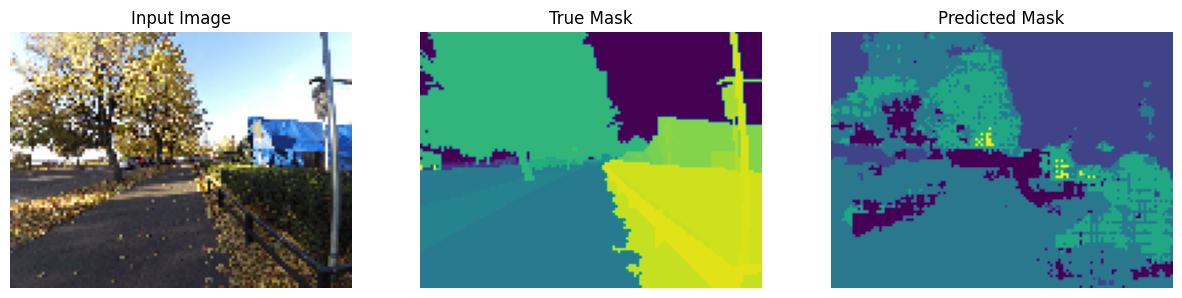

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


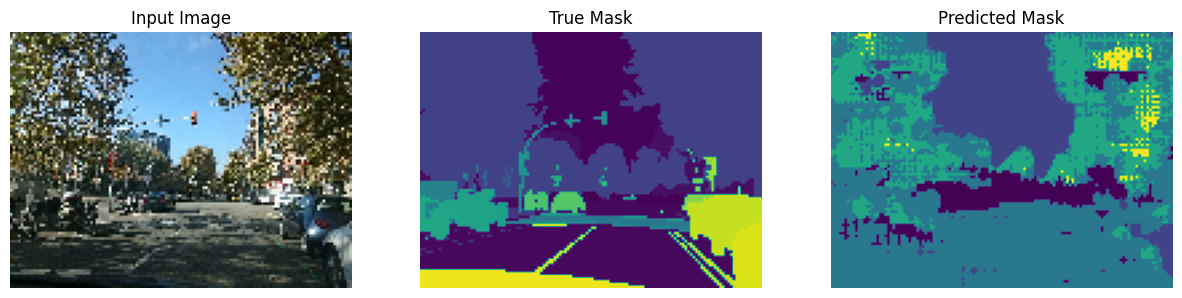

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


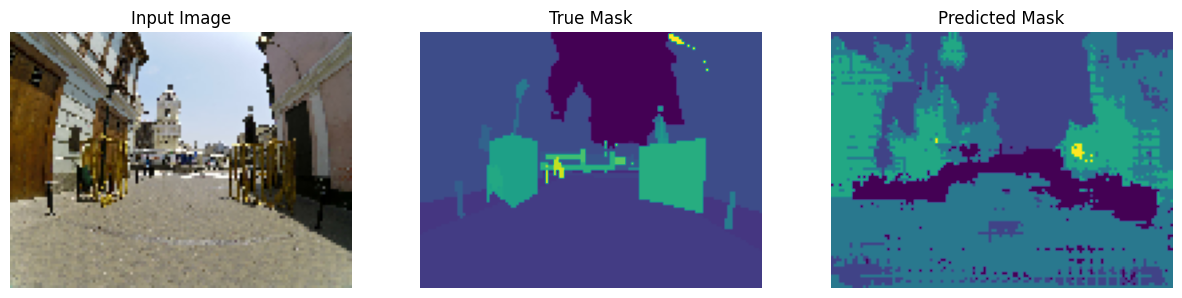

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


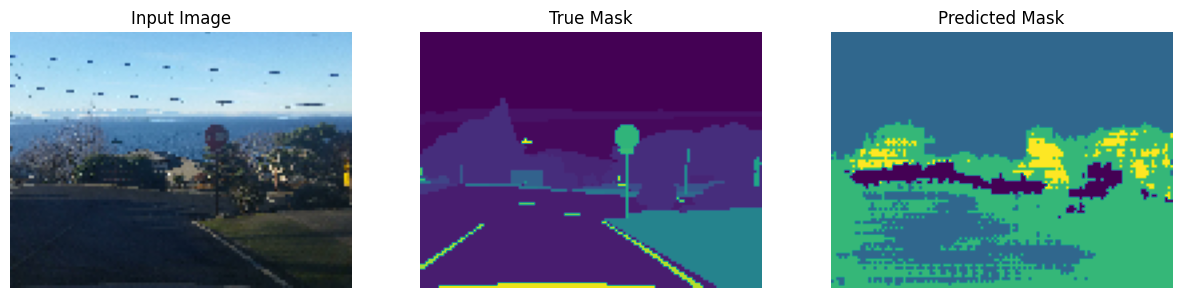

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


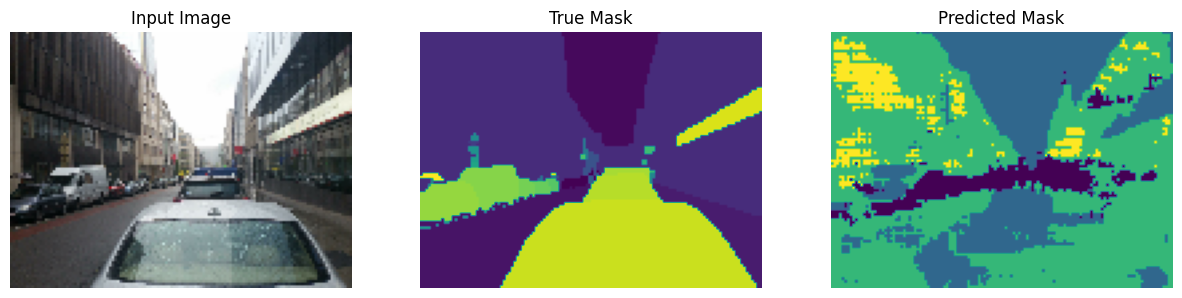

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


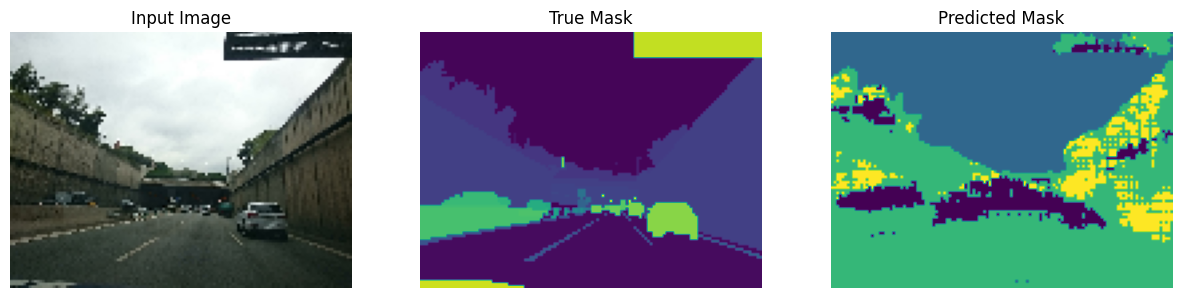

In [22]:
show_predictions(train_dataset, 6)

In [23]:
def preprocess_test(image):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    return input_image

In [1]:

# import os
# import cv2  # Assuming you're using OpenCV to load images
# import numpy as np
# import tensorflow as tf

# # Assuming test_masks_folder contains the ground truth masks
# test_masks_folder = "test_masks"

# # Load ground truth masks
# true_masks = []
# for image_path in test_image_list:
#     mask_path = os.path.join(test_masks_folder, os.path.basename(image_path))
#     true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#     true_masks.append(true_mask)

# # Make predictions using the trained model
# pred_masks = []
# for test_image in test_image_ds.take(len(test_image_list)):
#     test_image = test_image[tf.newaxis, ...]
#     pred_mask = model.predict(test_image)
#     pred_masks.append(pred_mask)

# def create_rgb_mask(mask):
#     """
#     Converts a single-channel mask to a three-channel RGB mask
#     """
#     return cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

# def convert_mask_color(mask, color_scheme):
#     """
#     Converts a mask's color scheme according to the given color_scheme dictionary
#     """
#     converted_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)  # Create an empty RGB mask
#     for value in color_scheme:
#         converted_mask[mask == value] = color_scheme[value]
#     return converted_mask

# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors

# def show_test_predictions(test_images_preprocessed, pred_masks, true_masks, num=1):
#     """
#     Displays the first num images of the test set along with predicted and ground truth masks
#     """
#     cmap = plt.cm.viridis  # Use the 'viridis' colormap

#     for i, (test_image, pred_mask, true_mask) in enumerate(zip(test_images_preprocessed, pred_masks, true_masks)):
#         if i >= num:
#             break
        
#         display_list = [test_image, create_mask(pred_mask), true_mask]
#         title = ['Test Image', 'Predicted Mask', 'True Mask']
#         display(display_list, title, cmap)

# def display(display_list, title=None, cmap=None):
#     """
#     Displays a list of images with their corresponding titles
#     """
#     plt.figure(figsize=(15, 15))
#     for i in range(len(display_list)):
#         plt.subplot(1, len(display_list), i+1)
#         plt.title(title[i])
#         if cmap is not None and i == len(display_list) - 1:  # Apply colormap only to the last image
#             plt.imshow(display_list[i], cmap=cmap)
#         else:
#             plt.imshow(display_list[i])
#         plt.axis('off')
#     plt.show()

# # Display predictions for the test set along with ground truth
# show_test_predictions(test_image_ds, pred_masks, true_masks, num=17)



In [ ]:
def save_ghostunet_model(model, save_path):
    """
    Save the GhostUNet model in Keras format
    
    Args:
        model (tf.keras.Model): The trained GhostUNet model
        save_path (str): Filepath to save the model
    """
    import os
    
    # Ensure the save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save in Keras format
    model.save(save_path)
    print(f"Model saved to: {save_path}")

In [ ]:
save_ghostunet_model(model, './Lenet_saved_model/Lenet_model.keras')

In [ ]:
def calculate_model_metrics(model, X_test, y_test):
    """
    Calculate precision, recall, and other classification metrics
    
    Args:
        model (tf.keras.Model): Loaded trained model
        X_test (numpy.ndarray): Test input data
        y_test (numpy.ndarray): True test labels
    
    Returns:
        dict: Containing various classification metrics
    """
    # Predict probabilities and convert to class predictions
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=-1)
    y_true = np.argmax(y_test, axis=-1) if y_test.ndim > 1 else y_test

    # Calculate precision, recall, f1-score for each class
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None
    )

    # Overall metrics (macro average)
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro'
    )

    # Weighted average metrics
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Detailed classification report
    class_report = classification_report(y_true, y_pred)

    return {
        'per_class_precision': precision,
        'per_class_recall': recall,
        'per_class_f1_score': f1_score,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1_score': macro_f1,
        'weighted_precision': weighted_precision,
        'weighted_recall': weighted_recall,
        'weighted_f1_score': weighted_f1,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report
    }

# Load the saved model
loaded_model = tf.keras.models.load_model('./Lenet_saved_model/Lenet_model.keras')